# **What is the flow ?**

First I chose a disease , results shown here are for Astma only, for detailed results for the other case study, the report can be refered


In [1]:
%cd DATA

/home/ubuntu/workspace/GNNs-on-Biological-data/DATA


In [2]:
import pandas as pd
import sys
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import networkx as nx
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
import os.path as osp
import matplotlib.pyplot as plt
import time
from random import choice
import random

from torch_geometric.data import InMemoryDataset
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T

import torch
from torch_geometric.data import Data

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GNNExplainer

# from torch_geometric.utils import metric

specifying the specific disease that we want to work on to filter the data based on it and create graph later on for that

In [3]:
def filter_disease(disease_gene_association_file):
    columns = ['diseaseName', 'geneSymbol']
    df = pd.read_csv(disease_gene_association_file, sep='\t',usecols=columns)

    #is_disease =  df['diseaseName']=="Diabetes" # first disease to be examined , comment this for checking for other disease and uncooment following
    is_disease =  df['diseaseName']=="Asthma"
    df_disease = df[is_disease]
    return df_disease


In [4]:
def create_G(biogrid_file_name,df_disease):
    biogrid = open(biogrid_file_name, 'r')
    lines=biogrid.readlines()
    G=nx.Graph()
    for line in tqdm(lines):
        x=line.split()
        if df_disease['geneSymbol'].str.contains(x[0]).any():
            G.add_node(x[0],label=1)
        else:
            G.add_node(x[0],label=0)
        if df_disease['geneSymbol'].str.contains(x[1]).any(): 
            G.add_node(x[1],label=1)
        else:  
            G.add_node(x[1],label=0)
        G.add_edge(x[0], x[1])
      #  G.add_edge(x[0], x[0]) # i decided to include an edge from node to itself to have adj matrix with himself included
       # G.add_edge(x[1], x[1])
    biogrid.close()
    G=nx.convert_node_labels_to_integers(G)
    #print(nx.info(G))
    return G

In [5]:
#this function will randomly dismiss some nodes with label 0
def create_balanced_G(biogrid_file_name,df_disease):
    biogrid = open(biogrid_file_name, 'r')
    lines=biogrid.readlines()
    G=nx.Graph()
    ones=zeros=0
    i=0
    nums=[0]
    for line in tqdm(lines):
        x=line.split()
        if df_disease['geneSymbol'].str.contains(x[0]).any():
            G.add_node(x[0],label=1)
            ones+=1
        else :
          num=random.randint(0,4000)
          if num in nums:
             G.add_node(x[0],label=0)
             zeros+=1
             

        if df_disease['geneSymbol'].str.contains(x[1]).any(): 
            G.add_node(x[1],label=1)
            ones+=1
        else:
          num=random.randint(0,4000)
          if num in nums:
            G.add_node(x[1],label=0)
            zeros+=1
        
        if G.has_node(x[0]) and G.has_node(x[1]):
            G.add_edge(x[0], x[1])
        i+=1
        if i%100000 ==0:
            print("p = ",ones/(ones+zeros))
        

    biogrid.close()
    G=nx.convert_node_labels_to_integers(G)
    #print(nx.info(G))
    return G

In [6]:
#this function counts the lables 0 and 1 , and portion of them, to check if the graph is balanced or not
def attribute_counter(G):
  zeros=0
  ones=0
  for node in tqdm(list(G.nodes())):
    if G.nodes[node]['label']==0:
      zeros+=1
    else:
      ones+=1
  print("#zeros: ", zeros)
  print("#ones: ", ones)
  print("portion of ones " ,ones/(ones+zeros) )

In [7]:
print(" (0/6) started ")
#disease_gene_association_file="all_gene_disease_associations.tsv"  #current directory / this is real file not test file
disease_gene_association_file="curated_gene_disease_associations.tsv"
df_disease=filter_disease(disease_gene_association_file)
print(" (1/6) disease dataframe creation : done")
                   
#biogrid_file_name='Biogrid_REDUX.txt'
biogrid_file_name='Biogrid_4.4.199_Hs.txt'
G=create_G(biogrid_file_name,df_disease)
print(" (2/6) Graph creation : done")

 (0/6) started 
 (1/6) disease dataframe creation : done


100%|██████████| 716559/716559 [01:09<00:00, 10252.14it/s]


 (2/6) Graph creation : done


read the saved .gpickle format graph 

G denotes for original graph

and G ballanced denotes for balanced version of graph

In [8]:
nx.write_gpickle(G, "Neoplasms_main_curated.gpickle")

In [9]:

G = nx.read_gpickle("Asthma_main.gpickle")

In [10]:
print(nx.info(G))
print(G.nodes)
attribute_counter(G)

/tmp/ipykernel_774524/3525720437.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


Graph with 19281 nodes and 549843 edges
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,

100%|██████████| 19281/19281 [00:00<00:00, 3207741.68it/s]

#zeros:  17101
#ones:  2180
portion of ones  0.1130646750687205


In [11]:
balanced_G= create_balanced_G(biogrid_file_name,df_disease)

 14%|█▍        | 101476/716559 [00:09<00:56, 10847.11it/s]

p =  0.9846318799142244


 28%|██▊       | 201133/716559 [00:19<00:49, 10418.71it/s]

p =  0.9832812787065957


 42%|████▏     | 301518/716559 [00:29<00:45, 9182.45it/s] 

p =  0.9803025977733372


 56%|█████▌    | 401537/716559 [00:39<00:30, 10436.25it/s]

p =  0.9792075776828001


 70%|██████▉   | 501533/716559 [00:49<00:20, 10390.48it/s]

p =  0.9799874921826142


 84%|████████▍ | 601726/716559 [00:59<00:10, 10938.05it/s]

p =  0.978070521416739


 98%|█████████▊| 701974/716559 [01:08<00:01, 10457.78it/s]

p =  0.9768664563617245


100%|██████████| 716559/716559 [01:10<00:00, 10208.61it/s]


In [12]:
nx.info(balanced_G)
attribute_counter(balanced_G)

/tmp/ipykernel_774524/1665640830.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(balanced_G)
100%|██████████| 429/429 [00:00<00:00, 2842585.18it/s]

#zeros:  321
#ones:  108
portion of ones  0.2517482517482518


In [13]:
nx.write_gpickle(G, "Neoplasms_more_balanced_curated.gpickle")

In [14]:
balanced_G = nx.read_gpickle("Asthma_balanced_more.gpickle")
nx.info(balanced_G)
attribute_counter(balanced_G)

/tmp/ipykernel_774524/2125148266.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(balanced_G)
100%|██████████| 7362/7362 [00:00<00:00, 3009597.08it/s]

#zeros:  7254
#ones:  108
portion of ones  0.014669926650366748


In [15]:
#we will run this only if the balanced graph is loaded, and we want to train model for thisvgraph
G=balanced_G

In [16]:
# retrieve the labels for each node, the nodes that are not zero
labels = np.asarray([G.nodes[i]['label'] != 0 for i in G.nodes]).astype(np.int64)

# create edge index. We need to have data as previously shown. We can exploit networkX and scipy for that 
adj = nx.to_scipy_sparse_matrix(G).tocoo() #coordinate format
#print(adj)

/tmp/ipykernel_774524/2791777853.py:5: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  adj = nx.to_scipy_sparse_matrix(G).tocoo() #coordinate format


In [17]:
#create edge index in the proper way
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long) #create a torch tensor from numpy in long format : for row indexes
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long) #                                                   for column indexes
edge_index = torch.stack([row, col], dim=0)
#display(edge_index)

In [18]:
# using degree as embedding. For simplicity, the feature vector describing the 
embeddings = np.array(list(dict(G.degree()).values())) #list the values of degree of each node as numpy array
# normalizing degree values
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1,1))
print(embeddings)

[[-0.24198427]
 [-0.07762897]
 [ 1.13449138]
 ...
 [-0.63232811]
 [-0.03654014]
 [ 0.08672633]]


In [19]:
# custom pytorch dataset
class PPIDATASET(InMemoryDataset):
    def __init__(self, transform=None):
        super(PPIDATASET, self).__init__('.', transform, None, None) #pre transform and pre filter: None, we don't need them
        data = Data(edge_index=edge_index) #Data : A data object describing a homogeneous graph.  for more : https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
        data.num_nodes = G.number_of_nodes()
        # embedding 
        data.x = torch.from_numpy(embeddings).type(torch.float32)
        # labels
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach() #removing tensors computational graph for efficency since it is not needed
        data.num_classes = 2
        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(G.nodes()),  pd.Series(labels), test_size=0.30, random_state=42)
        n_nodes = G.number_of_nodes()
        # create train and test masks for data
        # the Data objects holds a label for each node, and additional node-level attributes: train_mask, val_mask and test_mask, where
        #train_mask denotes against which nodes to train (140 nodes),
        #val_mask denotes which nodes to use for validation, e.g., t
        #test_mask denotes against which nodes to test 
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask
        self.data, self.slices = self.collate([data])
    # def _download(self):
    #     return
    # def _process(self):
    #     return
    # def __repr__(self):
    #     return '{}()'.format(self.__class__.__name__)


In [20]:
dataset = PPIDATASET()
#Here, the dataset contains only a single, undirected citation graph, reminder: dataset is like a dictionary that hold the graph inside, here the dictionary
#has only one elemetns:
data = dataset[0] #now data is ready for training and testing

In [21]:
# GCN model with 2 layers 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16) #in feature, out dim
        self.conv2 = GCNConv(16, int(data.num_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
data =  data.to(device)
model = Net().to(device) 

cuda


number of epochs to achive good result in different models can be different
for Asthma_main lets do for e=20

In [27]:
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

accuracy = Accuracy(task='binary').to(device)
precision = Precision(task='binary').to(device)
recall = Recall(task='binary').to(device)
f1 = F1Score(task='binary').to(device)
confmat = ConfusionMatrix(task='binary').to(device)

In [28]:
torch.manual_seed(42)

#optimizer_name = "Adam"
lr = 3e-4
#optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 21

def train():
  model.train()
  optimizer.zero_grad()
  #negative log likelihood, we need it after a softmax output activation function
  #we also tell to compute the loss using the  mask (so, on the train samples) 
  F.nll_loss(model(data)[data.train_mask], data.y[data.train_mask]).backward() 
  optimizer.step()
  
  # comment the following for avoiding eval during training
 # model.eval()
  logits = model(data)
  train_mask = data['train_mask']  # tensor with true or flases /which nodes are in train? !
  train_pred = logits[train_mask].max(1)[1] # tensor with zero or onoes . the elemets that were predicted !
  #train_acc = train_pred.eq(data.y[train_mask]).sum().item() / train_mask.sum().item() #eq: elementwise equality    > TP+TN/TP+TN+FP+FN
  train_pred = train_pred.view(-1).to(device)
  train_gt = data.y[train_mask].view(-1).to(device)

  train_acc = accuracy(train_pred, train_gt)
  train_precision = precision(train_pred, train_gt)
  train_f1score = f1(train_pred, train_gt)
  train_recall = recall(train_pred, train_gt)
  conf_matrix = confmat(train_pred, train_gt)
  
  TN, FP, FN, TP = conf_matrix.view(-1).tolist()
  return train_acc,train_precision,train_f1score,train_recall,TP,TN,FN,FP
  

In [29]:
@torch.no_grad()
def test():
  model.eval()
  logits = model(data)

  # uncomment the following if you want to eval on the train and test together
  # train_mask = data['train_mask']
  # train_pred = logits[train_mask].max(1)[1]
  # train_acc = train_pred.eq(data.y[train_mask]).sum().item() / train_mask.sum().item()

  test_mask = data['test_mask']
  test_pred = logits[test_mask].max(1)[1]
  
  test_pred = test_pred.view(-1).to(device)
  test_gt = data.y[test_mask].view(-1).to(device)
  
  test_acc = accuracy(test_pred, test_gt)
  test_precision = precision(test_pred, test_gt)
  test_f1score = f1(test_pred, test_gt)
  test_recall = recall(test_pred, test_gt)
  conf_matrix = confmat(test_pred, test_gt)
  
  TN, FP, FN, TP = conf_matrix.view(-1).tolist()

  return test_acc,test_precision,test_f1score,test_recall,TP,TN,FN,FP
  

In [30]:
tick=time.time()
for epoch in tqdm(range(1, epochs)):
   train_acc,train_precision,train_f1score,train_recall,TP_train,TN_train,FN_train,FP_train = train()
tock=time.time()

100%|██████████| 20/20 [00:00<00:00, 179.37it/s]


In [31]:
test_acc,test_precision,test_f1score,test_recall,TP_test,TN_test,FN_test,FP_test = test()

In [37]:
from torch_geometric.data.dataset import to_list
print('Train Accuracy: %s' % train_acc.item())
print('Train precision: %s' % train_precision.item())
print('Train f1 score: %s' % train_f1score.item())
print('Train recall: %s' % train_recall.item())
print(" #### confusion matrix test: ")
print( "TP",TP_train,"FP",FP_train)
print("TN", TN_train,"FN",FN_train)
print("train time:", tock-tick, "seconds")
print('Test Accuracy: %s' % test_acc.item())
print('test precision: %s' % test_precision.item())
print('Test f1 score: %s' % test_f1score.item())
print('Test recall: %s' % test_recall.item())
print(" #### confusion matrix test: ")
print( "TP",TP_test,"FP",FP_test)
print("TN", TN_test,"FN",FN_test)

Train Accuracy: 0.9778769612312317
Train precision: 0.0416666679084301
Train f1 score: 0.033898305147886276
Train recall: 0.02857142873108387
 #### confusion matrix test: 
TP 2 FP 46
TN 5037 FN 68
train time: 0.1130673885345459 seconds
Test Accuracy: 0.9827976226806641
test precision: 0.0
Test f1 score: 0.0
Test recall: 0.0
 #### confusion matrix test: 
TP 0 FP 0
TN 2171 FN 38


# **for Asthma_main with 20 epochs**

Train Accuracy: 0.8478067575577949

Train precision: 0.09104938060045242

Train f1 score: 0.05432780832052231

Train recall: 0.038713909685611725
 #### confusion matrix train: 
TP 59 FN 1465

TP 589 FN 11383

train time: 22.917723178863525 seconds   without GPU

Test Accuracy: 0.8866032843560934

test precision: 0.0

Test f1 score: 0.0

Test recall: 0.0

 #### confusion matrix test: 
TP 0 FP 0

TN 5129 FN 656

# **for balanced version of asthma with 20 epochs :**

train Accuracy: 0.40029254022428085

Train precision: 0.28345388174057007

Train f1 score: 0.33764132857322693

Train recall: 0.4174433946609497

 #### confusion matrix train: 

TP 627 FN 875

TP 1585 FN 1015

train time: 7.233067989349365 seconds

Test Accuracy: 0.4115974985787379

test precision: 0.3237907290458679

Test f1 score: 0.38793614506721497

Test recall: 0.4837758243083954

 #### confusion matrix test: 

TP 328 FP 685

TN 396 FN 350


In [38]:
torch.manual_seed(42)

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16, normalize=False)
        self.conv2 = GCNConv(16, dataset.num_classes, normalize=False)

    def forward(self, x, edge_index, edge_weight):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
lr = 1e-1

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 200

x, edge_index, edge_weight = data.x, data.edge_index, None

num_epochs = 200

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index, edge_weight)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

with torch.no_grad():
  model.eval()
  logits = model(x, edge_index, edge_weight)

  #test_mask = data['test_mask']
  preds = logits.max(1)[1]

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 1368.54it/s]


In [46]:
print(x.shape, edge_index.shape)

torch.Size([7362, 1]) torch.Size([2, 458861])


In [40]:
explainer = GNNExplainer(model, epochs=200, return_type='log_prob', num_hops = 2) #if num_hops is none it is detected from the num of message passing ops.
                                                                                  #it is needed to tell the explainer "how far to go" to look for explanations.
node_idx = 1 
pred_node_idx = preds[node_idx].item()
print("Explaining node ", node_idx, " with predicted class: ", pred_node_idx)

node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index, edge_weight=edge_weight)

Explaining node  1  with predicted class:  0


Explain node 1: 100%|██████████| 200/200 [00:00<00:00, 1058.02it/s]


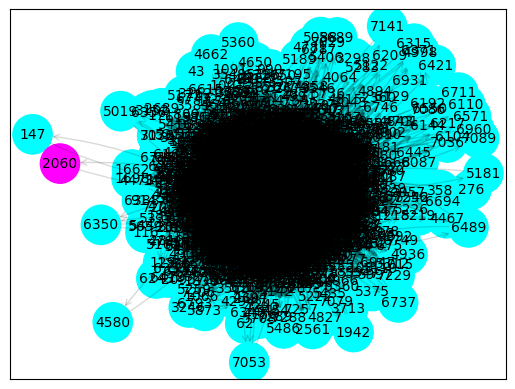

In [41]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y, seed = node_idx, threshold = None) #you can set threshold to define the hard mask accordign to the sparisty you wnat ot obtain and how much you want to be strict
plt.show()